# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

%matplotlib inline
import sklearn.metrics as skl_metrics

import utils
from utils import plot_rocs

## Read Data (DLCST results)

In [2]:
## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else ""
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
## Read DLCST results
df_results = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0


In [4]:
len(pd.unique(df_results['SeriesInstanceUID'])), len(pd.unique(df_results['PatientID']))

(599, 599)

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [6]:
df_results.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,599.000000,5.990000e+02,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,5.990000e+02,599.000000,599.000000
mean,1883.756260,2.005100e+07,58.397329,1.460768,0.170284,0.676127,1.769616,0.025965,0.040542,0.050433,0.058651,0.067412,0.089968,0.055902,1.461987e-01,0.166094,0.098497
std,1215.815006,7.593265e+03,4.946103,0.498875,0.376196,0.468343,1.165421,0.080576,0.104781,0.111505,0.115754,0.121409,0.135617,0.118722,2.966031e-01,0.241460,0.298235
min,4.000000,2.004111e+07,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.820000e-07,0.000574,0.000000
25%,800.500000,2.005013e+07,54.000000,1.000000,0.000000,0.000000,1.000000,0.001170,0.002554,0.007835,0.012797,0.019229,0.032957,0.002396,2.369950e-04,0.011600,0.000000
50%,1689.000000,2.005052e+07,58.000000,1.000000,0.000000,1.000000,1.000000,0.001965,0.005733,0.010996,0.015721,0.021112,0.035951,0.007804,2.825316e-03,0.045436,0.000000
75%,3011.500000,2.005103e+07,62.000000,2.000000,0.000000,1.000000,2.000000,0.007145,0.020146,0.029786,0.039906,0.051451,0.076318,0.044897,6.282042e-02,0.201205,0.000000
max,4099.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,9.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,9.988375e-01,0.977596,1.000000


<Axes: xlabel='Age', ylabel='Count'>

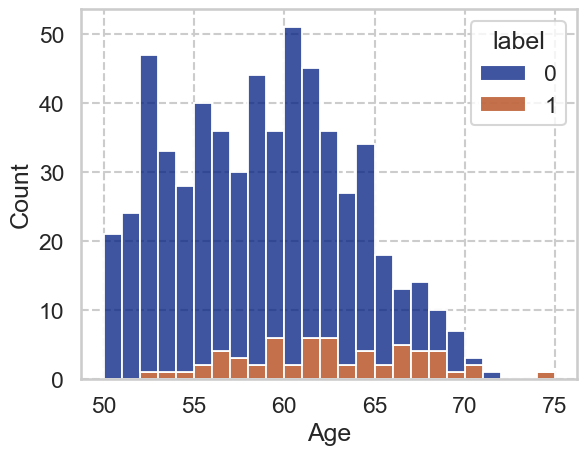

In [7]:
sns.histplot(df_results, x="Age", bins=25, hue="label", multiple='stack')

In [8]:
df_results.query('Age == 70')['label'].value_counts()

label
1    2
0    1
Name: count, dtype: int64

In [9]:
df_malignant = df_results.query('label == 1')
df_malignant.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,2226.067797,2.006203e+07,62.000000,1.457627,0.271186,0.745763,1.711864,0.145046,0.200687,0.222831,0.240233,0.258463,0.307859,0.221539,0.698916,0.616382,1.0
std,1146.619783,1.472711e+04,4.856563,0.502478,0.448388,0.439169,1.175187,0.179729,0.218469,0.226036,0.228718,0.236872,0.248971,0.201549,0.336146,0.273137,0.0
min,62.000000,2.004112e+07,52.000000,1.000000,0.000000,0.000000,1.000000,0.000421,0.002048,0.006331,0.010185,0.014170,0.022664,0.003140,0.000115,0.007771,1.0
25%,1303.500000,2.005072e+07,59.000000,1.000000,0.000000,0.500000,1.000000,0.010938,0.023848,0.040202,0.056078,0.068311,0.104660,0.050493,0.528134,0.474855,1.0
50%,2218.000000,2.005121e+07,62.000000,1.000000,0.000000,1.000000,1.000000,0.084456,0.143517,0.172521,0.197799,0.211975,0.276596,0.167578,0.833620,0.678868,1.0
75%,3300.500000,2.007056e+07,66.000000,2.000000,1.000000,1.000000,2.000000,0.215565,0.306710,0.306925,0.337119,0.365862,0.415215,0.296643,0.971705,0.837449,1.0
max,4032.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,7.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,0.998838,0.977596,1.0


### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [10]:
SPLIT_QUERIES = {
    "Sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "FamilyHistoryLungCa": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "Emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "Age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "NoduleCountPerScan": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

In [11]:
def get_split_dfs(df, split_by="SEX", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## Compare ROCs across models

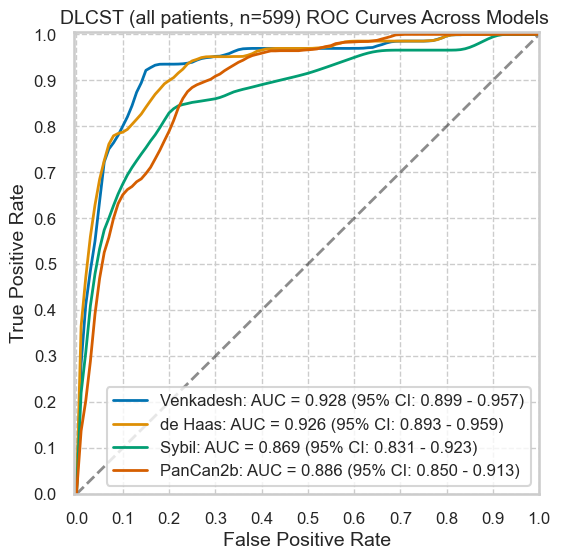

In [12]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

def rocs_models(df, true_col='label', models=["Venkadesh", "de Haas", "Sybil", "PanCan2b"], dataset_label="DLCST", subset_label="all", imgpath=None, plot_ci=False):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} ({subset_label} patients, n={len(df)}) ROC Curves Across Models ', imgpath, plot_ci)

rocs_models(df_results)

## Pick group for intersectional split

In [13]:
def rocs_splits(df, cat="sex", dataset_label="DLCST", true_col='label', models=MODEL_TO_COL, imgpath=None, plot_ci=False):
    groups = get_split_dfs(df, cat, printinfo=False).items()
    display(Markdown(f"#### {cat}"))
    df_catinfo, skips = utils.info_by_splits(groups, 2)
    display(df_catinfo)
    # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

    rocs = {}
    for m in models:
        rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
        print(m)
        display(df_perf)

    do_sigtest = (len(df_catinfo) - len(skips)) == 2
    bin_sigtest_results = {}

    fig, ax = plt.subplots(1, len(models), figsize=(6.5 * len(models) - 0.5, 6.5))
    fig.suptitle(f"Model Performance Split By {cat}")
    for i, m in enumerate(models):
        title_str = m
        if do_sigtest:
            z, p = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])
            title_str = f"{m}\n(z={z:.6f}, p={p:.6f})"
            bin_sigtest_results[m] = {"z": z, "p": p}

        utils.ax_rocs(ax[i], rocs[m], title=title_str)
    plt.show()

    df_sigtest_results = None
    if do_sigtest:
        df_sigtest_results = pd.DataFrame(bin_sigtest_results)
    
    display(df_sigtest_results)

    return df_sigtest_results

    # rocs = {}
    # rocs['all'] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[model]].values, df[true_col].values)   
    # for split, df_subset in subset_dfs.items():
    #     rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
    
    # plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

male, n=323, 32 malignant (9.91%)
female, n=276, 27 malignant (9.78%)


#### Sex

,num,pct,num_mal,pct_mal
male,323,53.923205,32,9.907121
female,276,46.076795,27,9.782609


Venkadesh


,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,32,291,28,40,251,4,0.875,0.137457,0.125,0.862543,0.411765,0.984314,0.588235,0.015686,0.863777,0.737543,0.560000,0.540486
female,276,27,249,27,56,193,0,1.000,0.224900,0.000,0.775100,0.325301,1.000000,0.674699,0.000000,0.797101,0.775100,0.490909,0.502137


de Haas


,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,32,291,30,104,187,2,0.9375,0.357388,0.0625,0.642612,0.223881,0.989418,0.776119,0.010582,0.671827,0.580112,0.361446,0.351763
female,276,27,249,27,108,141,0,1.0000,0.433735,0.0000,0.566265,0.200000,1.000000,0.800000,0.000000,0.608696,0.566265,0.333333,0.336531


Sybil


,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,32,291,18,15,276,14,0.562500,0.051546,0.437500,0.948454,0.545455,0.951724,0.454545,0.048276,0.910217,0.510954,0.553846,0.504019
female,276,27,249,13,11,238,14,0.481481,0.044177,0.518519,0.955823,0.541667,0.944444,0.458333,0.055556,0.909420,0.437305,0.509804,0.461063


PanCan2b


,num,mal,ben,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,32,291,22,31,260,10,0.687500,0.106529,0.312500,0.893471,0.415094,0.962963,0.584906,0.037037,0.873065,0.580971,0.517647,0.468658
female,276,27,249,19,51,198,8,0.703704,0.204819,0.296296,0.795181,0.271429,0.961165,0.728571,0.038835,0.786232,0.498884,0.391753,0.340643


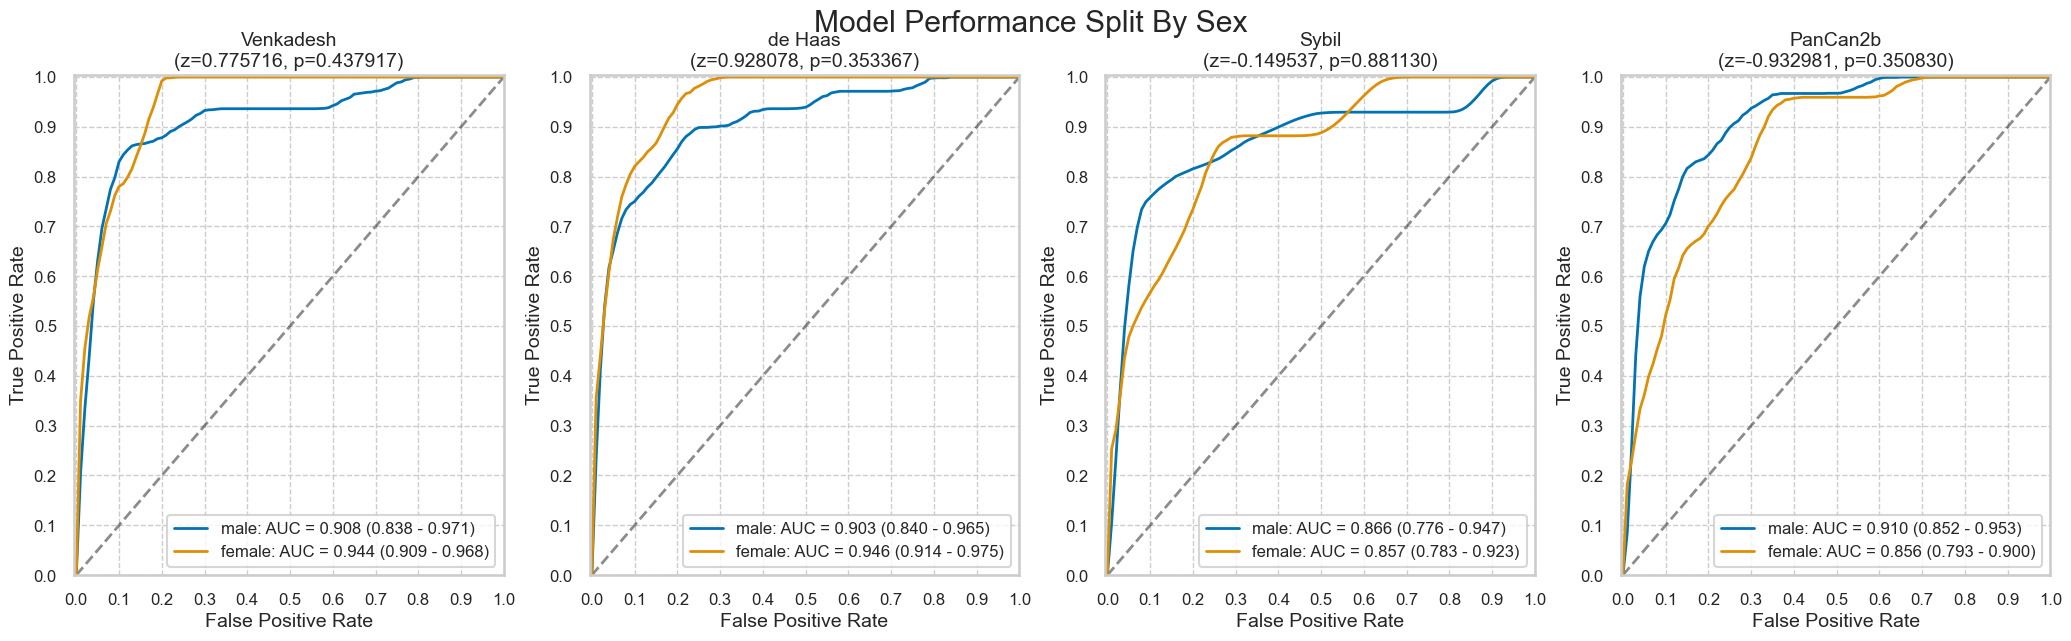

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.775716,0.928078,-0.149537,-0.932981
p,0.437917,0.353367,0.881130,0.350830


In [16]:
INTER_CAT = 'Sex'
INTER_GROUPS = get_split_dfs(df_results, INTER_CAT)
_ = rocs_splits(df_results, INTER_CAT)

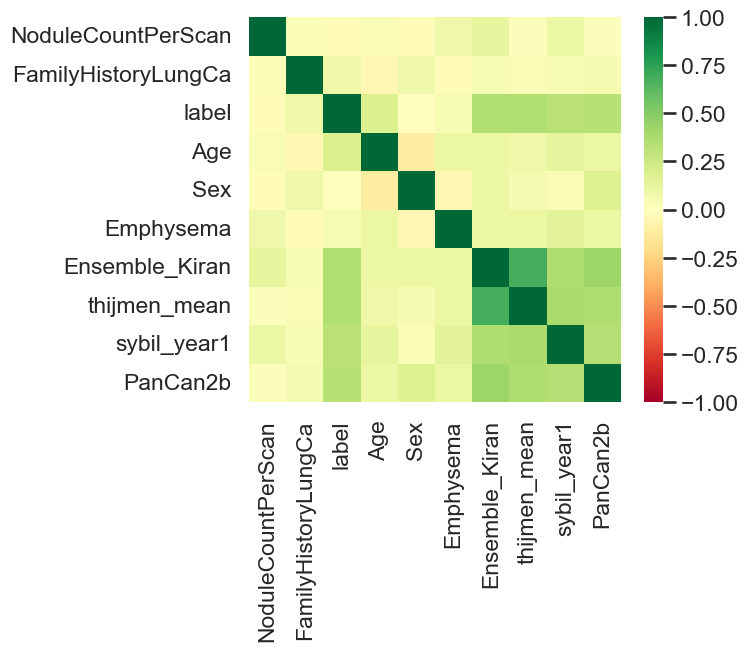

In [17]:
cols_list = list(set(['Age','Sex','FamilyHistoryLungCa','Emphysema','NoduleCountPerScan'] + [INTER_CAT, 'label'])) + list(MODEL_TO_COL.values())
correlations = utils.corrmat(df_results, cols_list, cols_list)

## Plot Splits for Same Model

In [18]:
def roc_intersection(df, cat="sex", models=MODEL_TO_COL):
    if cat == INTER_CAT: return
    for splitval in INTER_GROUPS: 
        splitdf = INTER_GROUPS[splitval]
        groups = get_split_dfs(splitdf, cat, printinfo=False).items()
        display(Markdown(f"#### {cat}: {INTER_CAT} = {splitval}"))
        df_catinfo, skips = utils.info_by_splits(groups, 2)
        display(df_catinfo)
        # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

        rocs = {}
        for m in models:
            rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
            # print(m)
            # display(df_perf)

        do_sigtest = (len(df_catinfo) - len(skips)) == 2
        bin_sigtest_results = {}

        fig, ax = plt.subplots(1, len(models), figsize=(6.5 * len(models) - 0.5, 6.5))
        fig.suptitle(f"Model Performance Split By {cat}")
        for i, m in enumerate(models):
            title_str = m
            if do_sigtest:
                z, p = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])
                title_str = f"{m}\n(z={z:.6f}, p={p:.6f})"
                bin_sigtest_results[m] = {"z": z, "p": p}

            utils.ax_rocs(ax[i], rocs[m], title=title_str)
        plt.show()

        df_sigtest_results = None
        if do_sigtest:
            df_sigtest_results = pd.DataFrame(bin_sigtest_results)
        
        display(df_sigtest_results)

        # rocs = {}
        # rocs['all'] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[model]].values, df[true_col].values)   
        # for split, df_subset in subset_dfs.items():
        #     rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
        
        # plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

#### FamilyHistoryLungCa: Sex = male

,num,pct,num_mal,pct_mal
no,277,85.758514,26,9.386282
yes,46,14.241486,6,13.043478


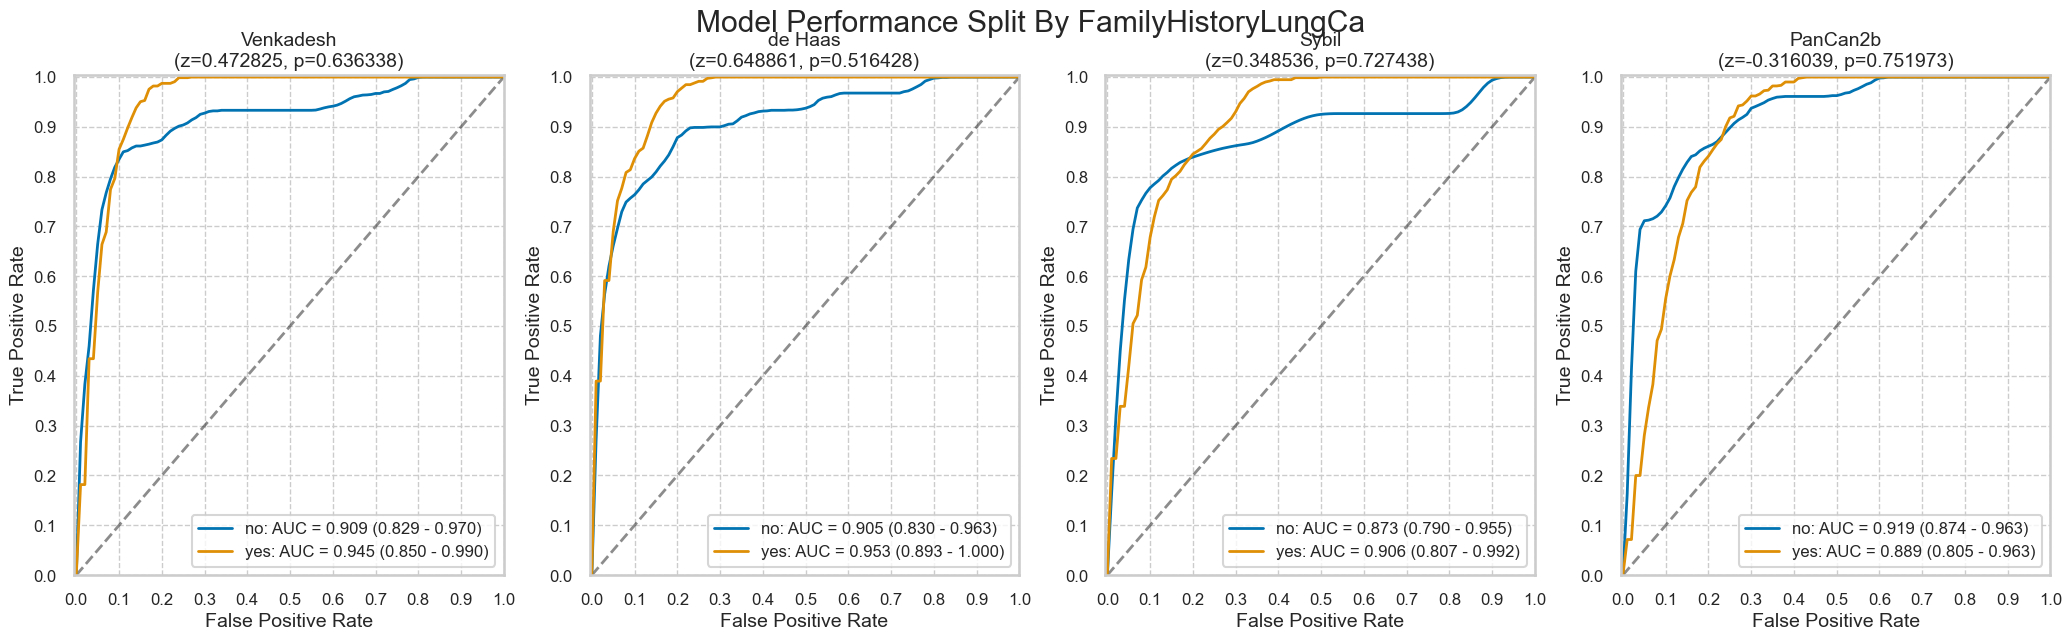

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.472825,0.648861,0.348536,-0.316039
p,0.636338,0.516428,0.727438,0.751973


#### FamilyHistoryLungCa: Sex = female

,num,pct,num_mal,pct_mal
no,220,79.710145,17,7.727273
yes,56,20.289855,10,17.857143


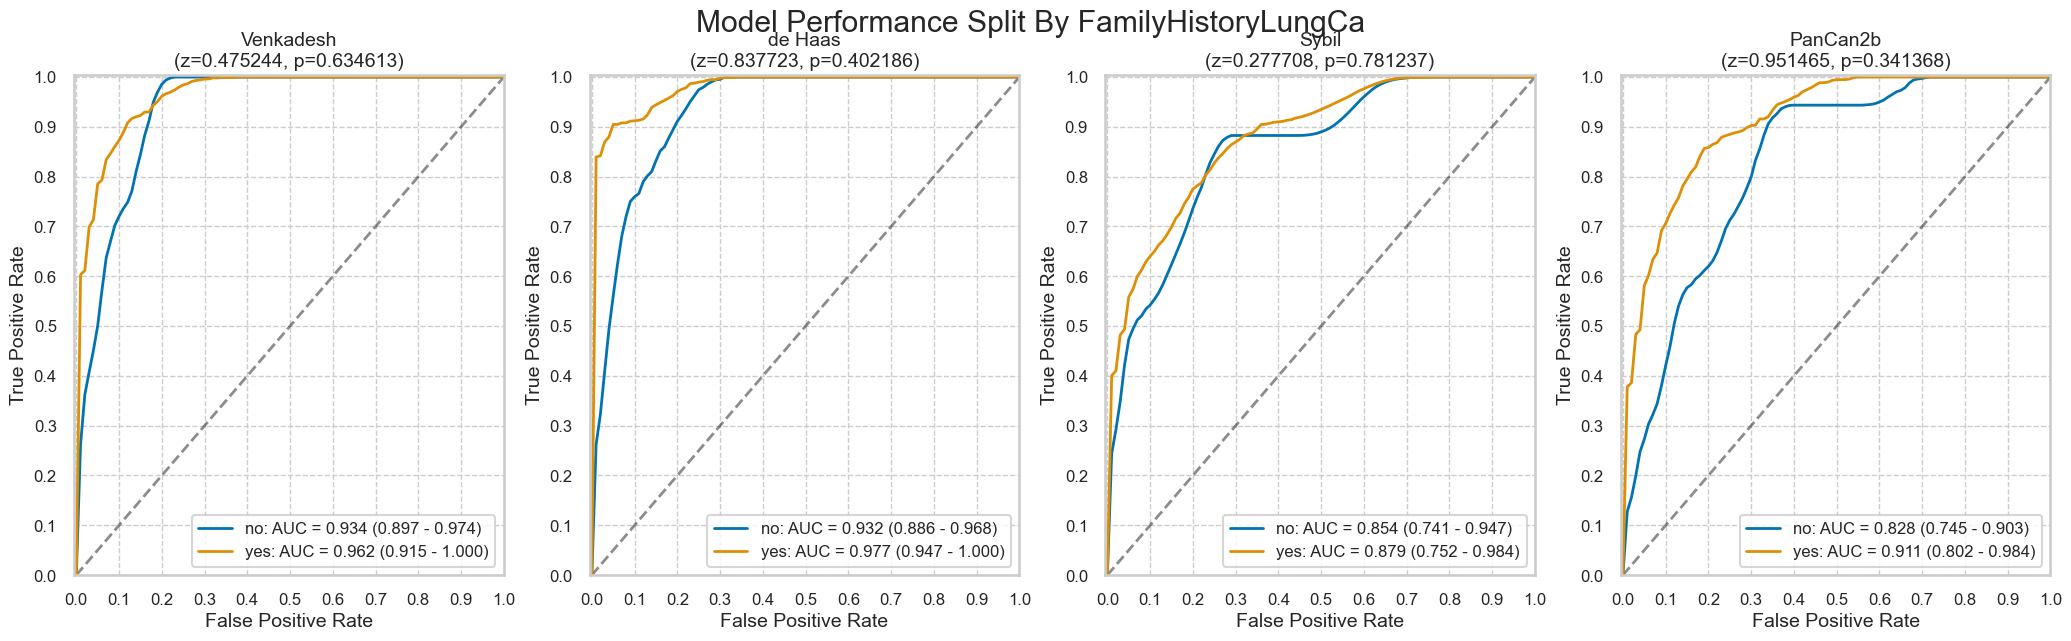

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.475244,0.837723,0.277708,0.951465
p,0.634613,0.402186,0.781237,0.341368


#### Emphysema: Sex = male

,num,pct,num_mal,pct_mal
no,97,30.03096,4,4.123711
yes,226,69.96904,28,12.389381


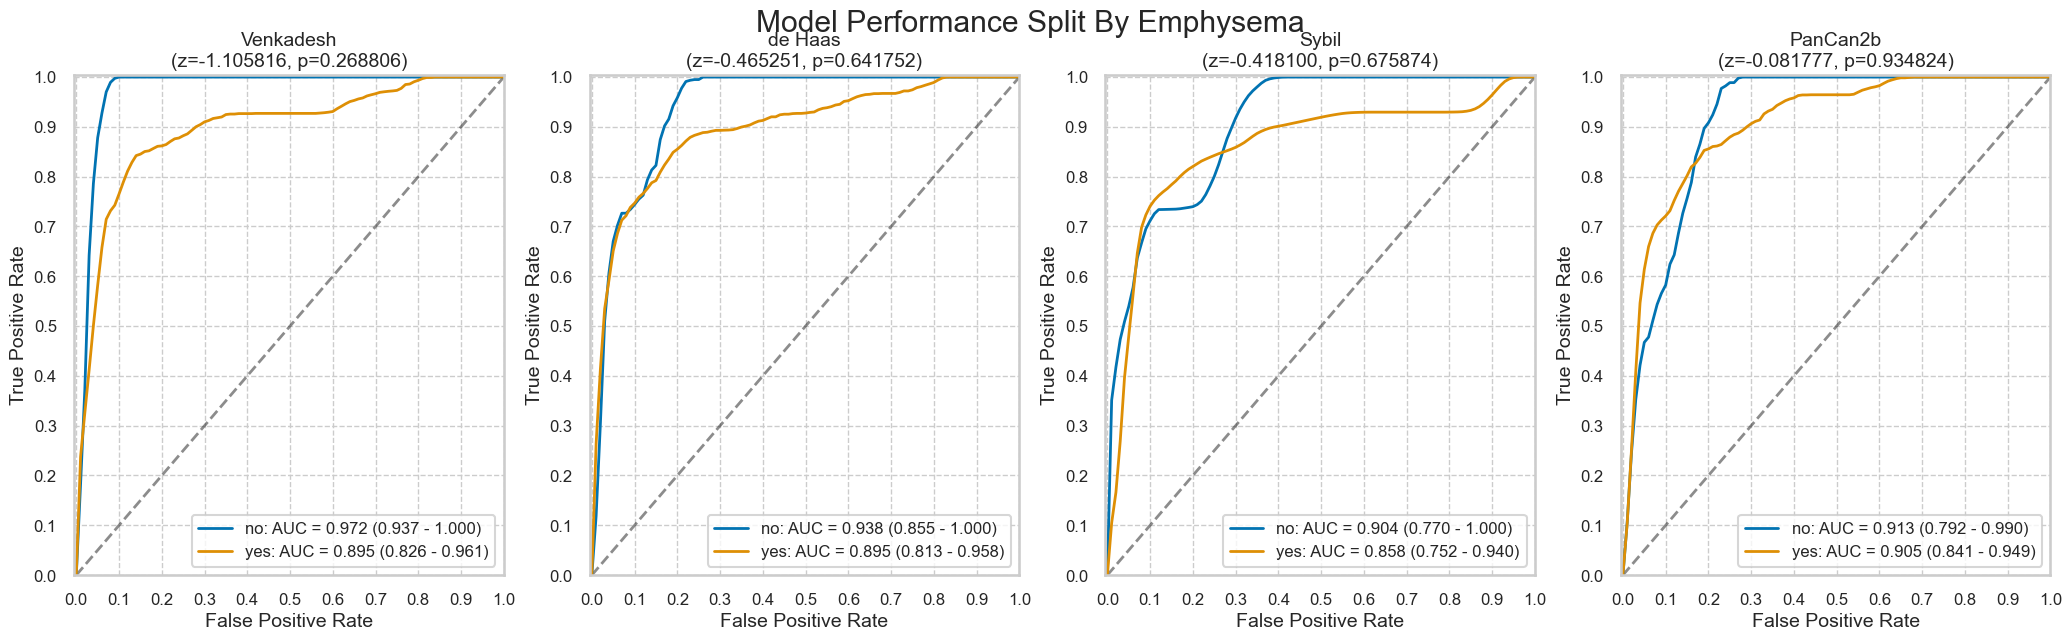

,Venkadesh,de Haas,Sybil,PanCan2b
z,-1.105816,-0.465251,-0.418100,-0.081777
p,0.268806,0.641752,0.675874,0.934824


#### Emphysema: Sex = female

,num,pct,num_mal,pct_mal
no,97,35.144928,11,11.340206
yes,179,64.855072,16,8.938547


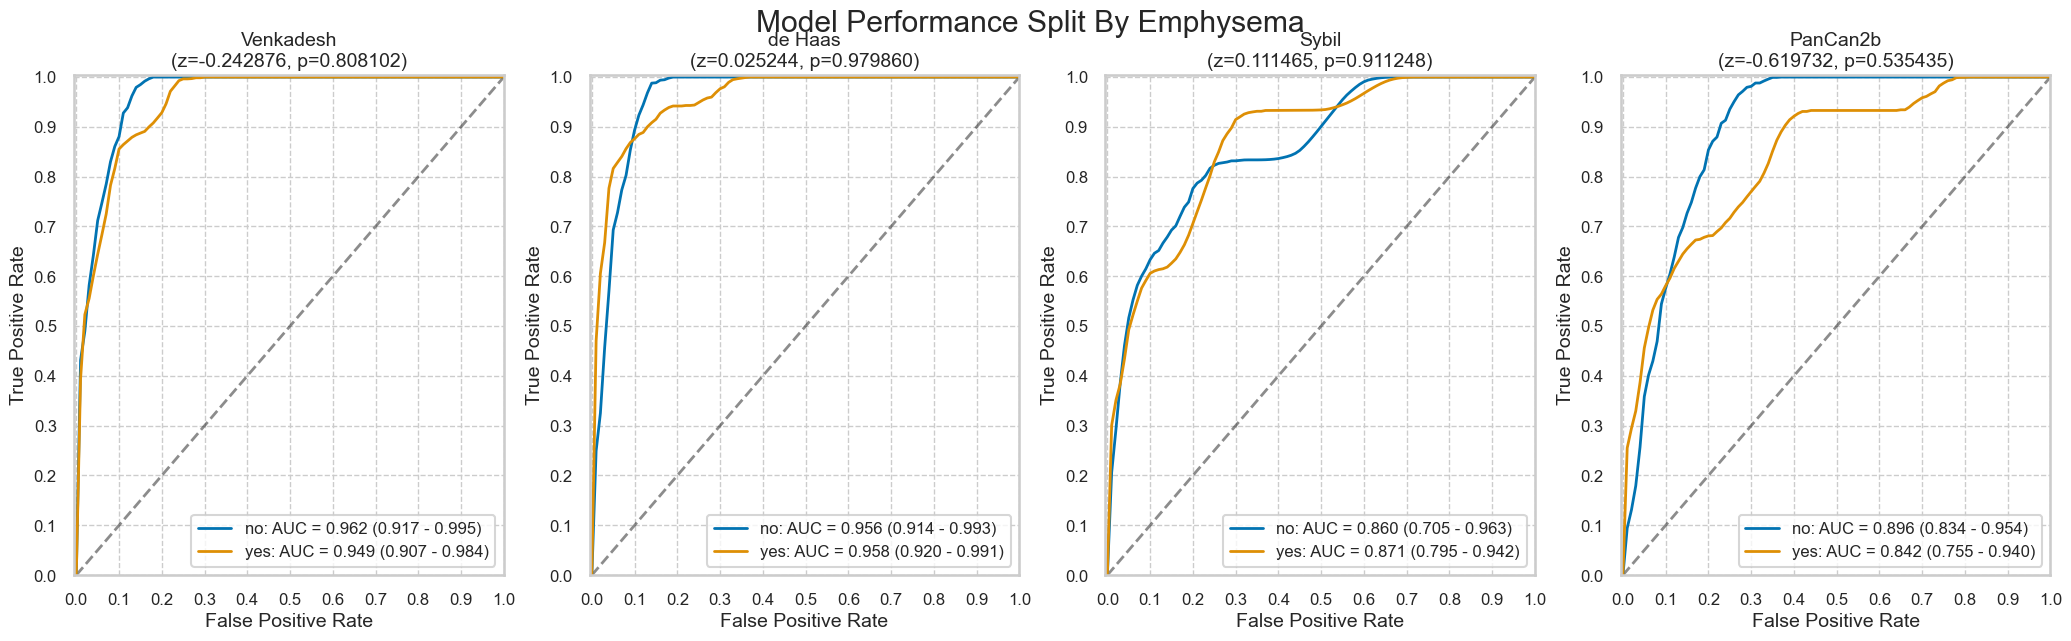

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.242876,0.025244,0.111465,-0.619732
p,0.808102,0.979860,0.911248,0.535435


#### Age: Sex = male

,num,pct,num_mal,pct_mal
50-62,221,68.421053,8,3.619910
62+,102,31.578947,24,23.529412


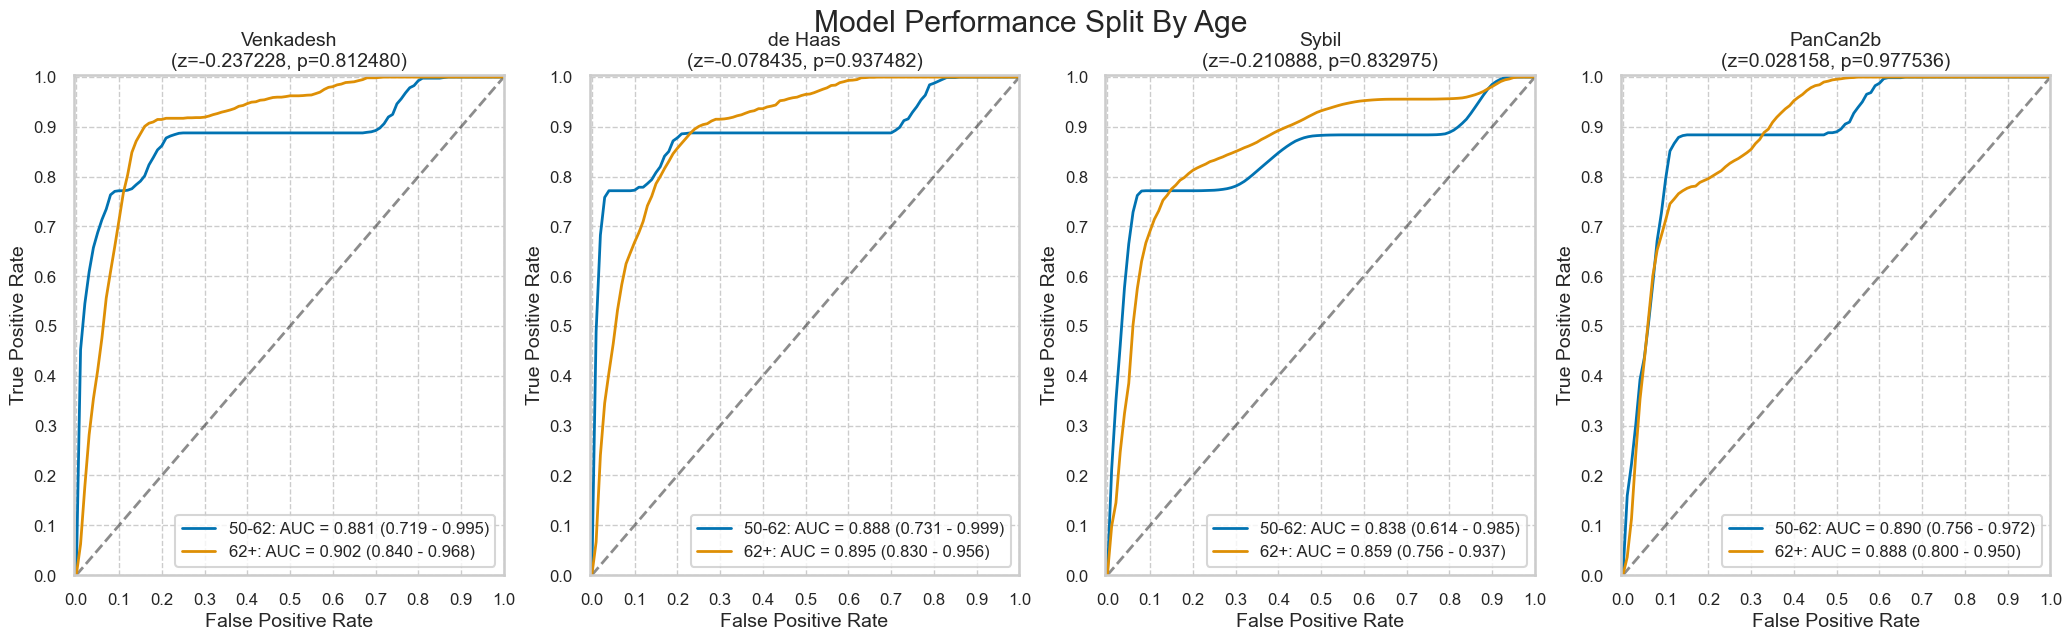

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.237228,-0.078435,-0.210888,0.028158
p,0.812480,0.937482,0.832975,0.977536


#### Age: Sex = female

,num,pct,num_mal,pct_mal
50-62,214,77.536232,20,9.345794
62+,62,22.463768,7,11.290323


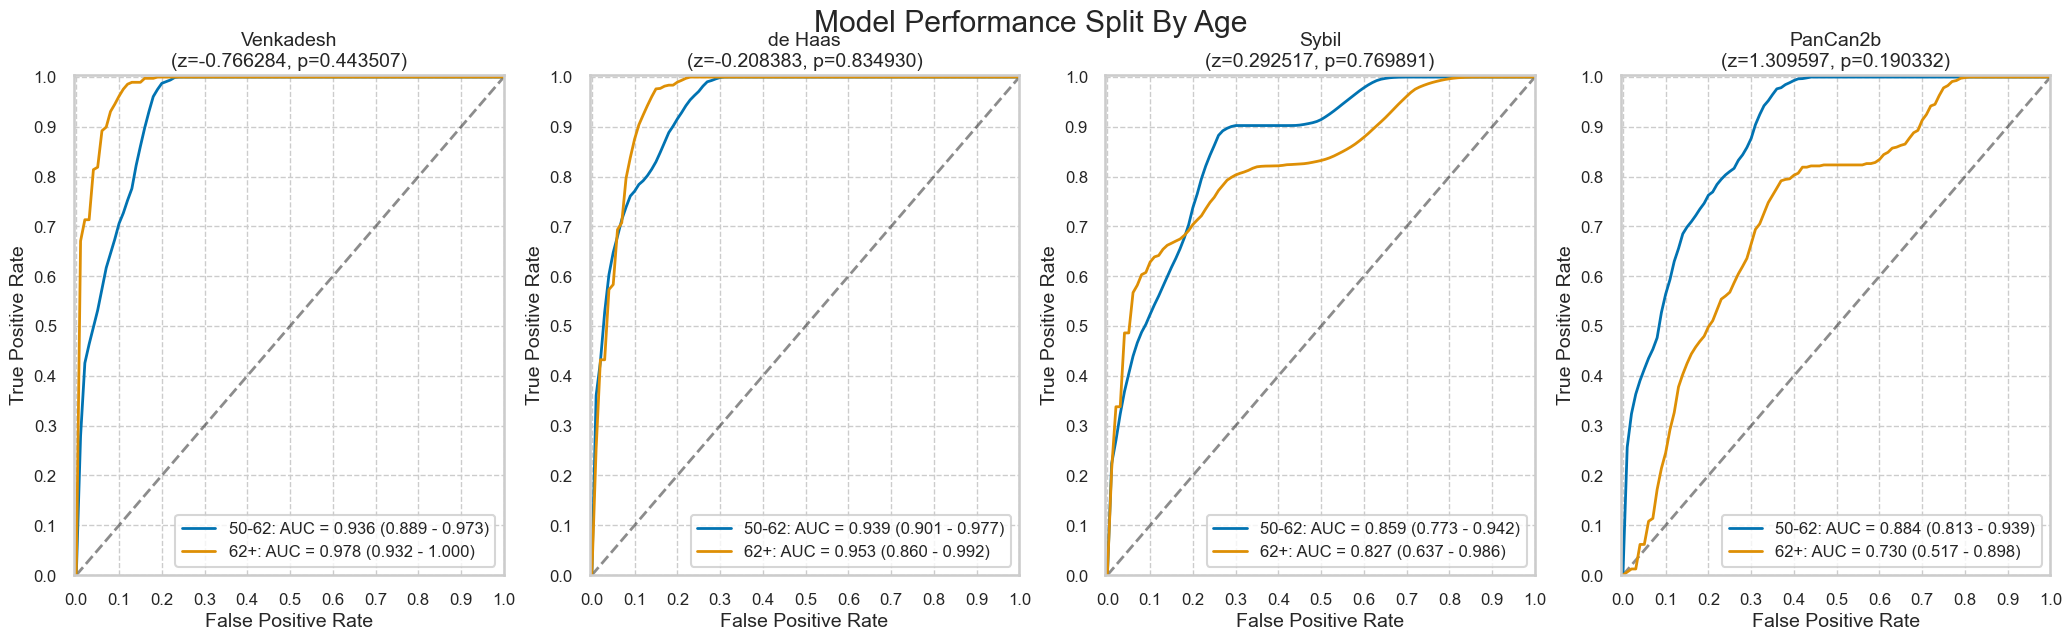

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.766284,-0.208383,0.292517,1.309597
p,0.443507,0.834930,0.769891,0.190332


#### NoduleCountPerScan: Sex = male

,num,pct,num_mal,pct_mal
1,176,54.489164,20,11.363636
>1,147,45.510836,12,8.163265


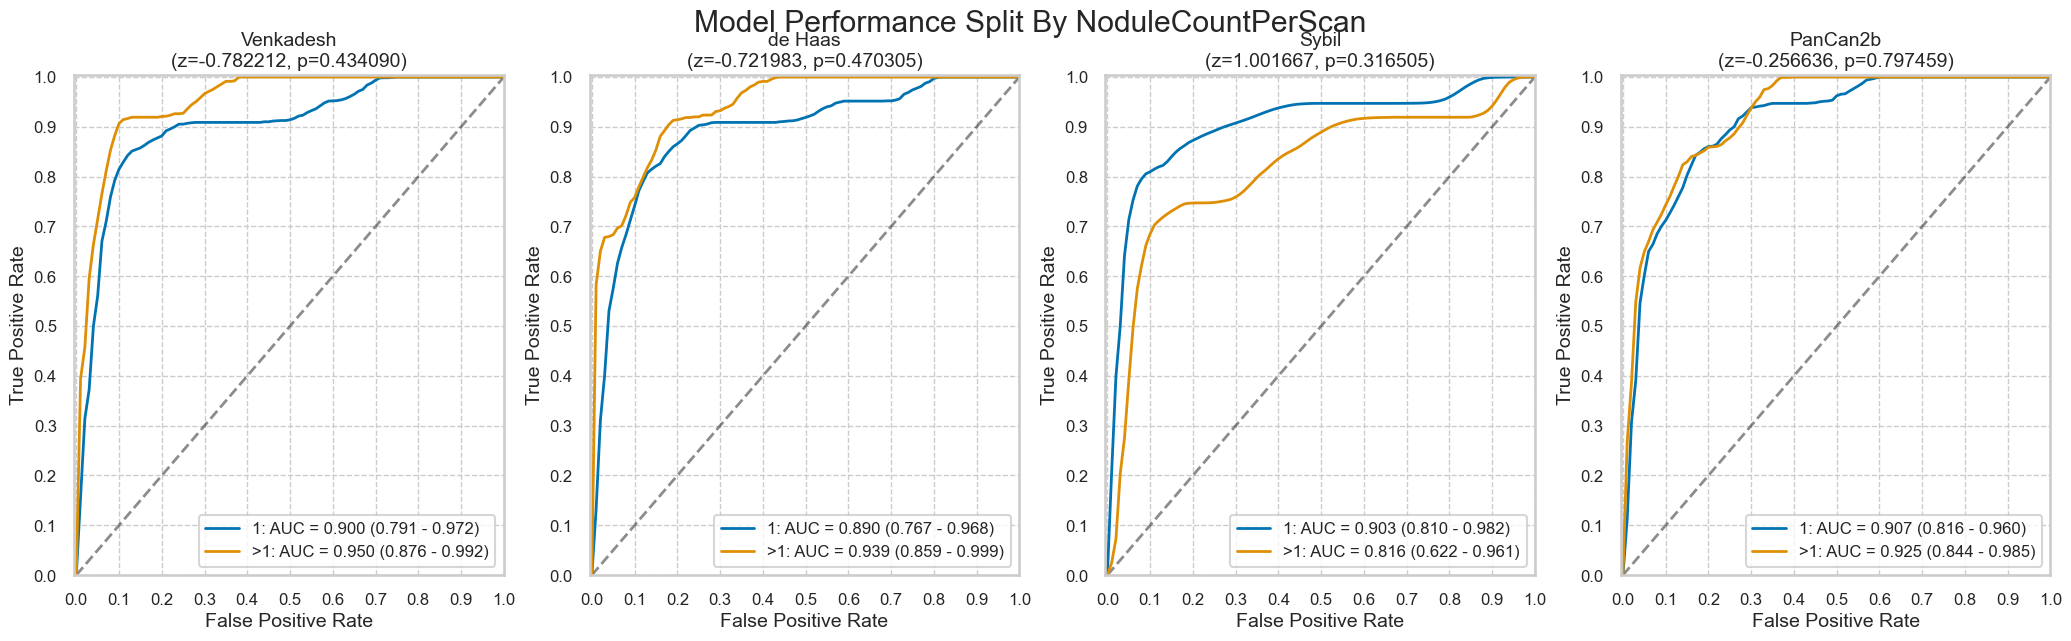

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.782212,-0.721983,1.001667,-0.256636
p,0.434090,0.470305,0.316505,0.797459


#### NoduleCountPerScan: Sex = female

,num,pct,num_mal,pct_mal
1,157,56.884058,15,9.554140
>1,119,43.115942,12,10.084034


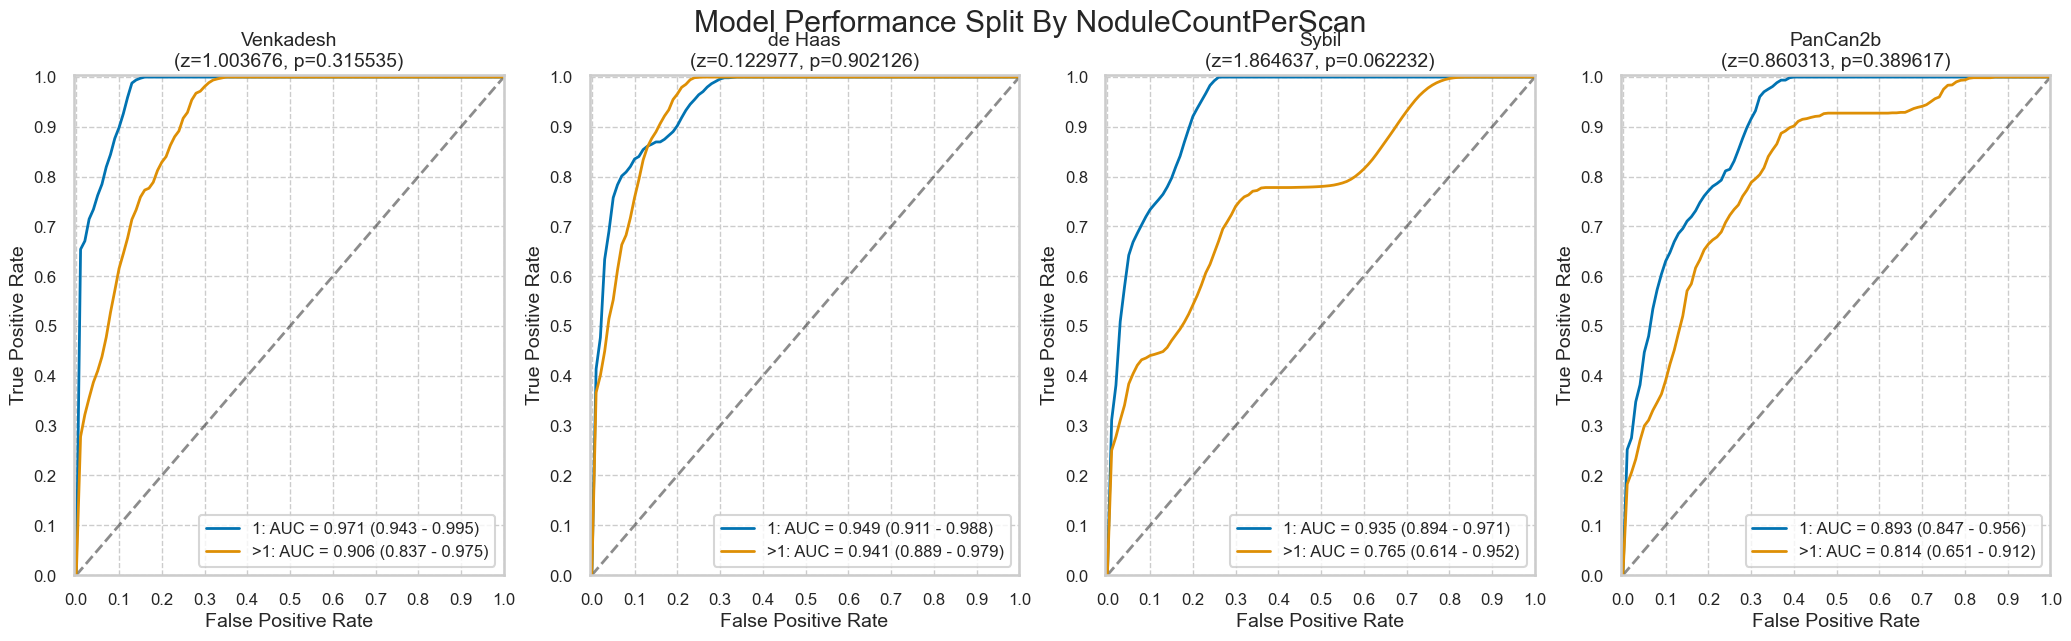

,Venkadesh,de Haas,Sybil,PanCan2b
z,1.003676,0.122977,1.864637,0.860313
p,0.315535,0.902126,0.062232,0.389617


In [19]:
for q in SPLIT_QUERIES:
    roc_intersection(df_results, q)